<a href="https://colab.research.google.com/github/starrycarina/Ditchley/blob/main/industry_theme_associations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neo4j
!pip install openai==0.28

In [ ]:
!pip install adjustText

In [ ]:
from neo4j import GraphDatabase
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
uri = "user = "password = "
driver = GraphDatabase.driver(uri, auth=(user, password))

In [ ]:
from datetime import datetime, timedelta

three_years_ago = datetime.today() - timedelta(days=3*365)
cutoff_date_str = three_years_ago.strftime("%d-%m-%Y")
print(cutoff_date_str)

24-07-2022


In [ ]:
def fetch_data(tx):
    query = """
    MATCH (c:Contact)
OPTIONAL MATCH (c)-[:ASSOCIATED_WITH]->(o:Organisation)-[:HAS_INDUSTRY]->(ind:Industry)
OPTIONAL MATCH (c)-[:HAS_THEME]->(th:Theme)
OPTIONAL MATCH (c)-[:HAS_SUBTHEME]->(sth:Subtheme)
MATCH (c)-[:INVITED]->(e:Event)
WHERE
  substring(e.startDateTime, 6, 4) + '-' +
  substring(e.startDateTime, 3, 2) + '-' +
  substring(e.startDateTime, 0, 2) >= '2022-07-23'
WITH c, o, ind,
     collect(DISTINCT th.name) AS themes,
     collect(DISTINCT sth.name) AS subthemes,
     collect(DISTINCT e.eventTitle) AS event_names,
     count(DISTINCT e) AS invited_count
OPTIONAL MATCH (c)-[:ATTENDED]->(ae:Event)
WHERE
  substring(ae.startDateTime, 6, 4) + '-' +
  substring(ae.startDateTime, 3, 2) + '-' +
  substring(ae.startDateTime, 0, 2) >= '2022-07-23'
WITH c, o, ind, themes, subthemes, event_names, invited_count,
     count(DISTINCT ae) AS attended_count
RETURN
  c.firstName AS first_name,
  c.surname AS last_name,
  o.name AS organisation,
  ind.name AS industry,
  themes,
  subthemes,
  invited_count,
  attended_count,
  event_names
ORDER BY attended_count DESC

    """
    return list(tx.run(query))

with driver.session(database="neo4j") as session:
    records = session.execute_read(fetch_data)

driver.close()

/tmp/ipython-input-96-3444712879.py:39: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.



In [ ]:
import pandas as pd

# create dataframe with updated columns
df = pd.DataFrame(
    records,
    columns=[
        'first_name', 'last_name', 'organisation', 'industry',
        'themes', 'subthemes', 'invited_count', 'attended_count', 'event_names'
    ]
)

# create a single 'contact' column for uniqueness
df['contact'] = df['first_name'].fillna('') + ' ' + df['last_name'].fillna('')
df['contact'] = df['contact'].str.strip()

# (optional) drop the separate first/last names if you don't need them anymore
df = df.drop(columns=['first_name', 'last_name'])

# Unique contacts and industries
all_contacts = df['contact'].unique()
all_industries = df['industry'].unique()

# Unique themes and subthemes separately
all_themes = sorted({theme for sublist in df['themes'] for theme in sublist if theme})
all_subthemes = sorted({subtheme for sublist in df['subthemes'] for subtheme in sublist if subtheme})

# Build binary contact-theme matrix
df_themes = df[['contact', 'themes']].explode('themes')
df_themes = df_themes.dropna(subset=['themes'])  # remove rows with no theme
contact_theme = pd.crosstab(df_themes['contact'], df_themes['themes'])
contact_theme = (contact_theme > 0).astype(int)

# Build binary contact-subtheme matrix
df_subthemes = df[['contact', 'subthemes']].explode('subthemes')
df_subthemes = df_subthemes.dropna(subset=['subthemes'])  # remove rows with no subtheme
contact_subtheme = pd.crosstab(df_subthemes['contact'], df_subthemes['subthemes'])
contact_subtheme = (contact_subtheme > 0).astype(int)

# Build contact-industry binary matrix
contact_industry = df.groupby(['contact', 'industry']).size().unstack(fill_value=0)
contact_industry = (contact_industry > 0).astype(int)

# (optional) you could also build event attendance info here if you like:
# list of events per contact:
df_events = df[['contact', 'event_names']].explode('event_names').dropna()
contact_event = pd.crosstab(df_events['contact'], df_events['event_names'])
contact_event = (contact_event > 0).astype(int)

# invited & attended counts per contact:
contact_counts = df.groupby('contact')[['invited_count', 'attended_count']].max()


In [ ]:
df

,organisation,industry,themes,subthemes,invited_count,attended_count,event_names,contact
0,The Ditchley Foundation,NGO/Nonprofit,"[Global Affairs / Defence / Commerce, Politics...","[Defence / National security, Centrist politic...",8,163,"[Oxfordshire community drinks - Autumn 2024, T...",James Arroyo
1,Foreign and Commonwealth Office (NOT IN USE),Politics,"[Global Affairs / Defence / Commerce, Politics...","[Defence / National security, Centrist politic...",8,163,"[Oxfordshire community drinks - Autumn 2024, T...",James Arroyo
2,"Foreign, Commonwealth and Development Office",Politics,"[Global Affairs / Defence / Commerce, Politics...","[Defence / National security, Centrist politic...",8,163,"[Oxfordshire community drinks - Autumn 2024, T...",James Arroyo
3,The Ditchley Foundation,NGO/Nonprofit,"[UK / Domestic, Global Affairs / Defence / Com...",[Other (specify)],28,69,"[Conf. Debrief: Long War in Ukraine, Conf. Deb...",Aydin Saribal
4,The Fabian Society,Academia,"[UK / Domestic, Global Affairs / Defence / Com...",[Other (specify)],28,69,"[Conf. Debrief: Long War in Ukraine, Conf. Deb...",Aydin Saribal
...,...,...,...,...,...,...,...,...
9244,None,None,[Geographical / Geopolitical Expertise],[Eastern Asia],3,0,"[Annual Lecture 2024 (V), Annual Lecture 2023 ...",Ping Huang
9245,None,None,"[Geographical / Geopolitical Expertise, Commun...","[Reporting / news, Western Europe, Southern Eu...",15,0,"[Annual Lecture 2023 (V), Conf Debrief: Evolvi...",Eric Reguly
9246,None,None,[],[],2,0,"[Bells of Congress Reception - 7 Sept, Confere...",Michael Hayden
9247,None,None,"[Science / Technology, Global Affairs / Defenc...","[Ethics / privacy, Cyber security, Defence / N...",3,0,"[Annual Lecture 2024 (V), Annual Lecture 2023 ...",Joel Molinoff


In [ ]:
def cramers_v(confusion_matrix):
    confusion_matrix = np.array(confusion_matrix)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    denominator = min((kcorr-1), (rcorr-1))
    if denominator == 0:
        return 0
    return np.sqrt(phi2corr / denominator)

In [ ]:
results = []

n_contacts = contact_industry.shape[0]

for industry in contact_industry.columns:
    p_industry = contact_industry[industry].sum() / n_contacts
    for theme in contact_theme.columns:
        p_theme = contact_theme[theme].sum() / n_contacts

        contingency = pd.crosstab(contact_industry[industry], contact_theme[theme])
        if contingency.shape[0] > 1 and contingency.shape[1] > 1:
            chi2, p, dof, ex = chi2_contingency(contingency)
            strength = cramers_v(contingency)

            joint_count = contingency.loc[1,1] if (1 in contingency.index and 1 in contingency.columns) else 0
            p_joint = joint_count / n_contacts

            # Avoid divide-by-zero errors
            if p_industry > 0 and p_theme > 0 and p_joint > 0:
                lift = p_joint / (p_industry * p_theme)
                pmi = np.log2(lift)
            else:
                lift = np.nan
                pmi = np.nan

            results.append({
                'industry': industry,
                'theme': theme,
                'p_value': p,
                'cramers_v': strength,
                'lift': lift,
                'pmi': pmi,
                'p_industry': p_industry,
                'p_theme': p_theme,
                'p_joint': p_joint,
                'joint_count': joint_count
            })

results_df = pd.DataFrame(results)

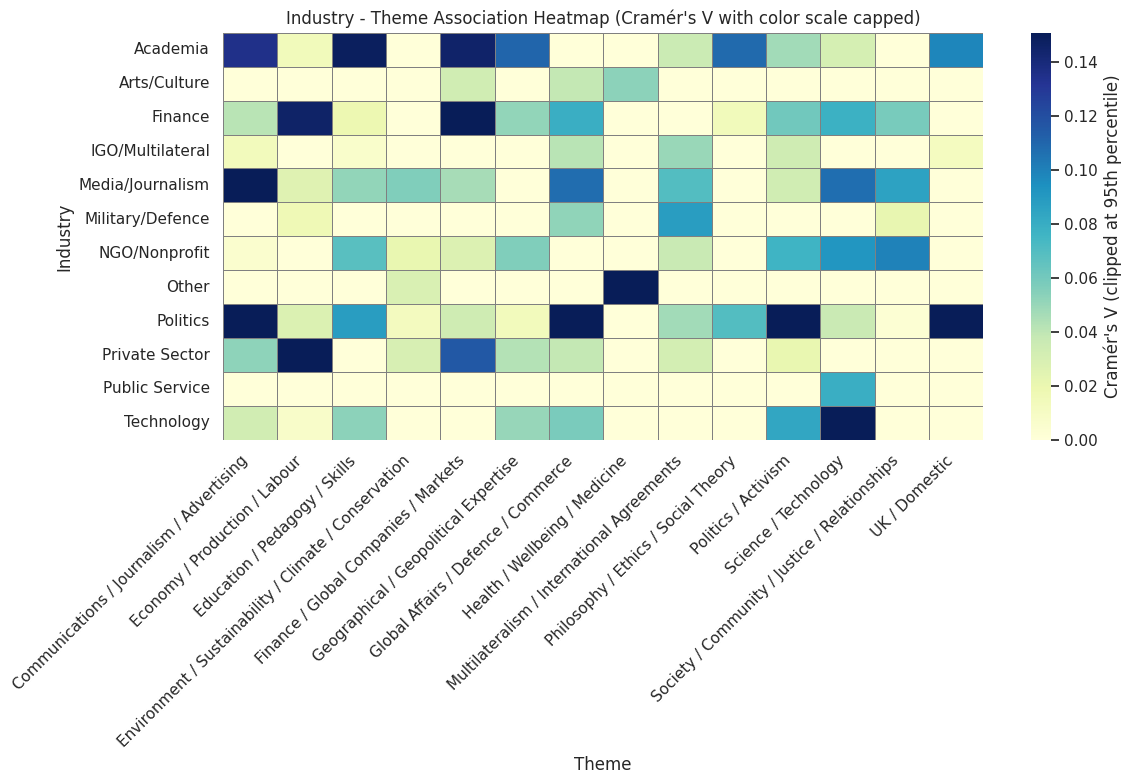

In [ ]:
# Pivot table with median cramers_v per industry-theme
heatmap_data = results_df.pivot_table(
    index='industry',
    columns='theme',
    values='cramers_v',
    aggfunc='median',
    fill_value=0
)

# Calculate upper limit (e.g. 95th percentile) for clipping the colors
vmax_clip = np.percentile(heatmap_data.values.flatten(), 95)
vmin_clip = 0  # usually 0 for Cramér's V

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    cmap='YlGnBu',
    linewidths=0.5,
    linecolor='gray',
    vmin=vmin_clip,
    vmax=vmax_clip,
    cbar_kws={'label': "Cramér's V (clipped at 95th percentile)"}
)

plt.title("Industry - Theme Association Heatmap (Cramér's V with color scale capped)")
plt.xlabel('Theme')
plt.ylabel('Industry')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


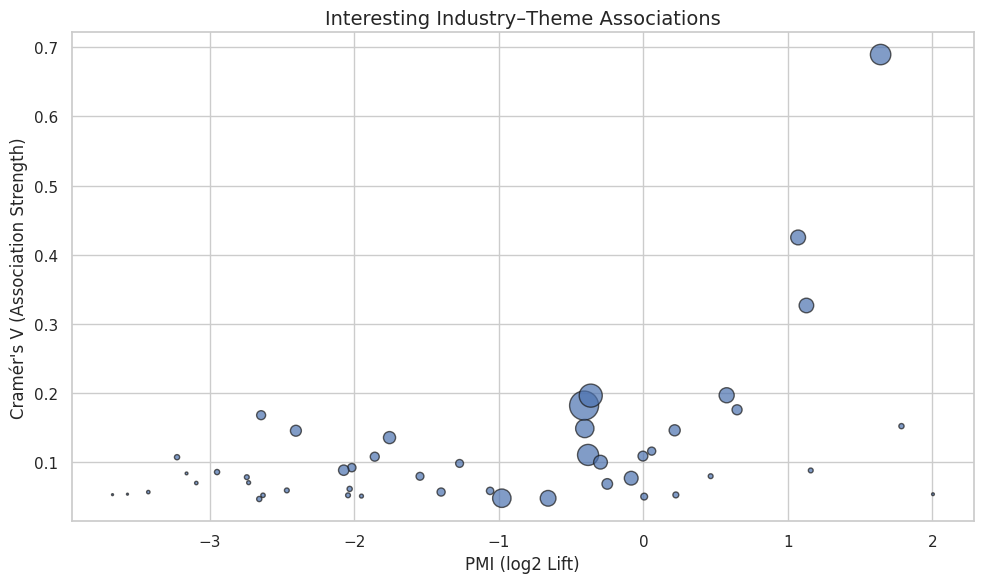

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter interesting points
interesting = results_df[
    (results_df['p_value'] < 0.05)
]

# Figure & style
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Scatter points with colors
plt.scatter(
    interesting['pmi'],
    interesting['cramers_v'],
    s=interesting['joint_count']*2,  # scale size
    alpha=0.7,
    edgecolors='k'
)

# KEEP axis labels and title
plt.xlabel('PMI (log2 Lift)', fontsize=12)
plt.ylabel("Cramér's V (Association Strength)", fontsize=12)
plt.title('Interesting Industry–Theme Associations', fontsize=14)

plt.tight_layout()
plt.show()


/tmp/ipython-input-102-1173006766.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



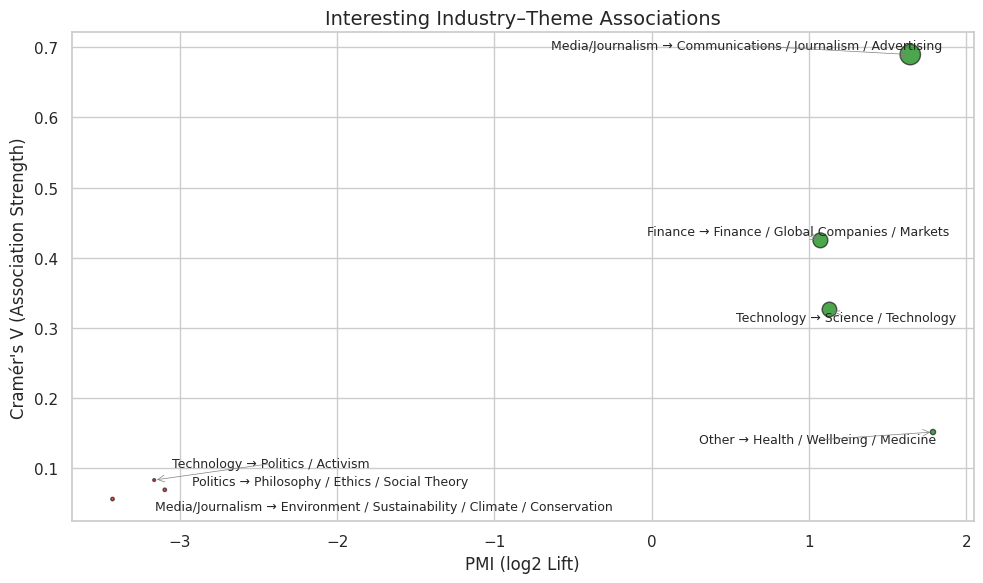

In [ ]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import seaborn as sns

# Filter interesting points
interesting = results_df[
    (results_df['p_value'] < 0.05) &
    (results_df['joint_count'] > 1) &
    (
        ((results_df['cramers_v'] > 0.1) & (results_df['pmi'] > 0.7)) |
        ((results_df['cramers_v'] < 0.1) & (results_df['pmi'] < -3))
    )
]

# Assign colors
def get_color(row):
    if (row['cramers_v'] > 0.1) and (row['pmi'] > 1):
        return 'green'  # top-right
    elif (row['cramers_v'] < 0.1) and (row['pmi'] < -3):
        return 'red'    # bottom-left
    else:
        return 'steelblue'

interesting['color'] = interesting.apply(get_color, axis=1)

# Figure & style
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Scatter points with colors
scatter = plt.scatter(
    interesting['pmi'],
    interesting['cramers_v'],
    s=interesting['joint_count']*2,  # scale size
    c=interesting['color'],
    alpha=0.7,
    edgecolors='k'
)

plt.xlabel('PMI (log2 Lift)', fontsize=12)
plt.ylabel("Cramér's V (Association Strength)", fontsize=12)
plt.title('Interesting Industry–Theme Associations', fontsize=14)

# Add text labels
texts = []
for i, row in interesting.iterrows():
    label = f"{row['industry']} → {row['theme']}"
    texts.append(
        plt.text(
            row['pmi'],
            row['cramers_v'],
            label,
            fontsize=9
        )
    )



adjust_text(
    texts,
    arrowprops=dict(arrowstyle="->", color='gray', lw=0.5),
    expand_points=(1.2, 1.4),
    expand_text=(1.5, 2.0),   # increase vertical expansion for text
    force_text=1.5,
    force_points=0.5,
    only_move={'points': 'y', 'text': 'y'},  # only move text vertically
    lim=300
)


plt.tight_layout()
plt.show()


In [ ]:
filtered_df = df[
    (df['industry'] == 'Media/Journalism') &
    (df['themes'].apply(lambda themes: 'Environment / Sustainability / Climate / Conservation' in themes))
]



# Select relevant columns: contact name and event names
result = filtered_df[['contact', 'event_names', 'invited_count','attended_count','organisation']]

grouped = filtered_df.groupby(['contact', 'invited_count', 'attended_count']).agg({
    'event_names': lambda x: sorted(set(sum(x, []))),  # flatten list of lists, remove duplicates, sort
    'organisation': lambda x: sorted(set(x.dropna()))  # unique orgs, sorted
}).reset_index()

# Sort by attended_count descending
grouped = grouped.sort_values(by='attended_count', ascending=False)

grouped


,contact,invited_count,attended_count,event_names,organisation
2,Sarah McFarlane,1,1,[Annual Lecture 2024 (V)],[Thomson Reuters]
0,David Sheppard,1,0,[Media Discussion December 2024],[The Financial Times]
1,John Kemp,2,0,"[Annual Lecture 2024 (V), Ditchley Winter Dial...",[Reuters Group plc]


In [ ]:
filtered_df = df[
    (df['industry'] == 'Technology') &
    (df['themes'].apply(lambda themes: 'Politics / Activism' in themes))
]



# Select relevant columns: contact name and event names
result = filtered_df[['contact', 'event_names', 'invited_count','attended_count','organisation']]

grouped = filtered_df.groupby(['contact', 'invited_count', 'attended_count']).agg({
    'event_names': lambda x: sorted(set(sum(x, []))),  # flatten list of lists, remove duplicates, sort
    'organisation': lambda x: sorted(set(x.dropna()))  # unique orgs, sorted
}).reset_index()

# Sort by attended_count descending
grouped = grouped.sort_values(by='attended_count', ascending=False)

grouped.head(10)

,contact,invited_count,attended_count,event_names,organisation
1,Katherine Townsend,2,2,"[Discussion Debrief: Internet Governance, Ditc...",[Open Data Collaboratives]
0,Aaron Kleiner,3,1,"[Annual Lecture 2023 (V), Discussion Debrief: ...","[Atlassian, Microsoft Corporation]"


In [ ]:
filtered_df = df[
    (df['industry'] == 'Politics') &
    (df['themes'].apply(lambda themes: 'Philosophy / Ethics / Social Theory' in themes))
]



# Select relevant columns: contact name and event names
result = filtered_df[['contact', 'event_names', 'invited_count','attended_count','organisation']]

grouped = filtered_df.groupby(['contact', 'invited_count', 'attended_count']).agg({
    'event_names': lambda x: sorted(set(sum(x, []))),  # flatten list of lists, remove duplicates, sort
    'organisation': lambda x: sorted(set(x.dropna()))  # unique orgs, sorted
}).reset_index()

# Sort by attended_count descending
grouped = grouped.sort_values(by='attended_count', ascending=False)

grouped.head(10)

,contact,invited_count,attended_count,event_names,organisation
2,Robert Cooper,36,2,"[Annual General Meeting 2023, Annual Lecture 2...","[Foreign and Commonwealth Office (NOT IN USE),..."
0,Annette Schavan,4,0,"[Annual Lecture 2024 (IP), Conference Debrief:...",[German Bundestag]
1,Onora O'Neill,3,0,"[Annual Lecture 2023 (IP), Annual Lecture 2023...",[House of Lords]
